## Reports with Python 

# Export from Yahoo Finance and plot data

In [6]:
import yfinance as yf
import pandas as pd

# Load historical data in the past 10 years
sp500 = yf.Ticker("^GSPC")
end_date = pd.Timestamp.today()
start_date = end_date - pd.Timedelta(days=10*365)
sp500_history=sp500.history(start=start_date, end=end_date)

# Remove unnecessary columns
sp500_history = sp500_history.drop(columns=['Dividends', 'Stock Splits'])

# Create a new column as Close 200 days moving average
sp500_history['Close_200ma'] = sp500_history['Close'].rolling(200).mean()

# Create a summary statistics table
sp500_history_summary = sp500_history.describe()

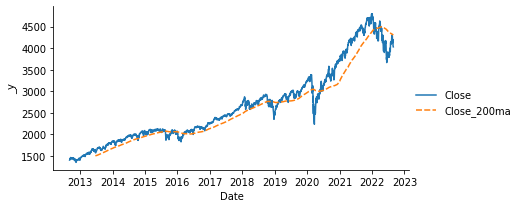

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.relplot(data=sp500_history[['Close', 'Close_200ma']], kind='line', height=3, aspect=2.0)
plt.savefig('chart.png')

# Transform into Excel

In [8]:
# Import libraries
from openpyxl.chart import LineChart, Reference

# 1. Set up an ExcelWriter
with pd.ExcelWriter('excel_report.xlsx', engine='openpyxl') as writer:
# 2. Export data
    sp500_history.to_excel(writer, sheet_name='historical_data')
    sp500_history_summary.to_excel(writer, sheet_name='historical_data_summary')
    
# 3. Add a line chart
    # Point to the sheet 'historical_data', where the chart will be added
    wb = writer.book 
    ws = wb['historical_data'] 
    # Grab the maximum row number in the sheet
    max_row = ws.max_row
    # Refer to the data of close and close_200ma by the range of rows and cols on the sheet
    values_close = Reference(ws, min_col=5, min_row=1, max_col=5, max_row=max_row)
    values_close_ma = Reference(ws, min_col=7, min_row=1, max_col=7, max_row=max_row)
    # Refer to the date
    dates = Reference(ws, min_col=1, min_row=2, max_col=1, max_row=max_row)
    # Create a LineChart
    chart = LineChart()
    # Add data of close and close_ma to the chart
    chart.add_data(values_close, titles_from_data=True)
    chart.add_data(values_close_ma, titles_from_data=True)
    # Set the dates as the x axis and format it
    chart.set_categories(dates)
    chart.x_axis.number_format = 'mmm-yy'
    chart.x_axis.majorTimeUnit = 'days'
    chart.x_axis.title = 'Date'
    # Add title to the chart
    chart.title = 'Close prices of S&P 500'
    # Refer to close_ma data, which is with index 1 within the chart, and style it
    s1 = chart.series[1]
    s1.graphicalProperties.line.dashStyle = 'sysDot'
    # Add the chart to the cell of G12 on the sheet ws
    ws.add_chart(chart, 'G12')